### Transfer Learning For emotion prediction
* I tried so much CNN  type (Lenet, Alexnet and many build my me) with and without feature extraction methods(HOG and LBP). I recieve the best result with using raw grayscale face detected data with 82% val_accuracy. Therefore, further work I will try to achieve my goal (90%) with using Transfer Learning 

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-02-22 16:19:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-22 16:19:33 (89.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
unzip_data("forFineTuningEx.zip")

In [ ]:
walk_through_dir("forFineTuningEx")

There are 2 directories and 0 images in 'forFineTuningEx'.
There are 7 directories and 0 images in 'forFineTuningEx/train'.
There are 0 directories and 124 images in 'forFineTuningEx/train/fear'.
There are 0 directories and 139 images in 'forFineTuningEx/train/sad'.
There are 0 directories and 153 images in 'forFineTuningEx/train/disgust'.
There are 0 directories and 191 images in 'forFineTuningEx/train/angry'.
There are 0 directories and 97 images in 'forFineTuningEx/train/neutral'.
There are 0 directories and 181 images in 'forFineTuningEx/train/surprised'.
There are 0 directories and 165 images in 'forFineTuningEx/train/happy'.
There are 7 directories and 0 images in 'forFineTuningEx/test'.
There are 0 directories and 30 images in 'forFineTuningEx/test/fear'.
There are 0 directories and 30 images in 'forFineTuningEx/test/sad'.
There are 0 directories and 30 images in 'forFineTuningEx/test/disgust'.
There are 0 directories and 30 images in 'forFineTuningEx/test/angry'.
There are 0 di

In [ ]:
# Create training and test directories
train_dir = "forFineTuningEx/train/"
test_dir = "forFineTuningEx/test/"

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (48, 48) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            color_mode="grayscale",
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                          color_mode="grayscale",
                                                                           label_mode="categorical")

Found 1050 files belonging to 7 classes.
Found 207 files belonging to 7 classes.


In [ ]:
train_data.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(7, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

27033600/27018416 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220219-212254
Epoch 1/5
22/22 [==============================] - 91s 4s/step - loss: 1.9376 - accuracy: 0.1882 - val_loss: 1.8974 - val_accuracy: 0.2011
Epoch 2/5
22/22 [==============================] - 72s 3s/step - loss: 1.7551 - accuracy: 0.3448 - val_loss: 1.7324 - val_accuracy: 0.3678
Epoch 3/5
22/22 [==============================] - 78s 4s/step - loss: 1.6086 - accuracy: 0.4684 - val_loss: 1.6431 - val_accuracy: 0.4253
Epoch 4/5
22/22 [==============================] - 71s 3s/step - loss: 1.4907 - accuracy: 0.5158 - val_loss: 1.5667 - val_accuracy: 0.5000
Epoch 5/5
22/22 [==============================] - 77s 4s/step - loss: 1.4048 - accuracy: 0.5733 - val_loss: 1.5210 - val_accuracy: 0.4368


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block1b_dwconv
18 block1b_bn
19 block1b_activation
20 block1b_se_squeeze
21 block1b_se_reshape
22 block1b_se_reduce
23 block1b_se_expand
24 block1b_se_excite
25 block1b_project_conv
26 block1b_project_bn
27 block1b_drop
28 block1b_add
29 block2a_expand_conv
30 block2a_expand_bn
31 block2a_expand_activation
32 block2a_dwconv_pad
33 block2a_dwconv
34 block2a_bn
35 block2a_activation
36 block2a_se_squeeze
37 block2a_se_reshape
38 block2a_se_reduce
39 block2a_se_expand
40 block2a_se_excite
41 block2a_project_conv
42 block2a_project_bn
43 block2b_expand_conv
44 block2b_expand_bn
45 block2b_expand_activation
46 block2b_dwconv
47 block2b_bn
48 block2b_activation
49 block2b_se_squeeze
50 block2b_se

In [ ]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________


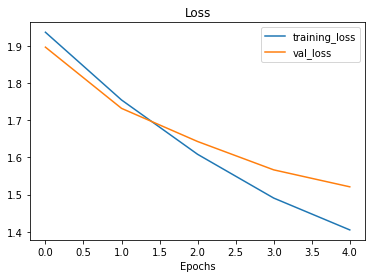

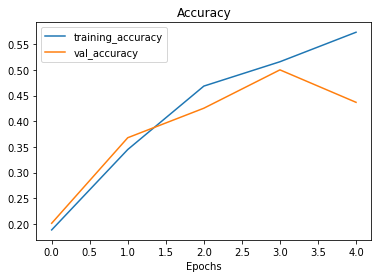

In [ ]:
plot_loss_curves(history_10_percent)

## Second model is will be data augmented model.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.1),
  preprocessing.RandomZoom(0.1),
  preprocessing.RandomHeight(0.1),
  preprocessing.RandomWidth(0.1),
  # preprocessing.Rescaling(1./255) we cannot use with efficient net
], name ="data_augmentation")

Examples from the dataset and it is augmented version

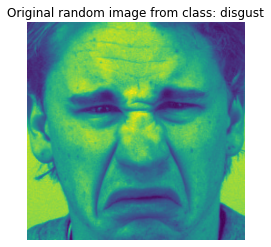

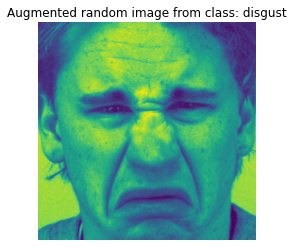

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = "forFineTuningEx/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Model_1- FeatureExtraction Transfer Learning With augmented Data

In [ ]:
# Create the base mdoel and freeze it is alyers
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB1(include_top=False)

# The input layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Layer
x= data_augmentation(inputs)

# Non trainable Efficient Net
x= base_model(x, training= False)

#Pool Layer Averaging or Max  can be tried
x= layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#The output layer we have 7 classes
outputs = layers.Dense(7, activation="softmax", name="output_layer")(x)

#Make the model
model_1=keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "data_aug_feature_extract")])






Saving TensorBoard log files to: transfer_learning/data_aug_feature_extract/20220219-215849
Epoch 1/5
22/22 [==============================] - 254s 11s/step - loss: 3.6100 - accuracy: 0.1494 - val_loss: 3.7493 - val_accuracy: 0.1609
Epoch 2/5
22/22 [==============================] - 233s 11s/step - loss: 2.0412 - accuracy: 0.1480 - val_loss: 1.9671 - val_accuracy: 0.1379
Epoch 3/5
10/22 [============>.................] - ETA: 1:58 - loss: 1.9717 - accuracy: 0.1219

KeyboardInterrupt: ignored

### Data Augmentation is not work for this project we already preprocess data 

* Using Model Check Point

In [ ]:
# Setup checkpoint path
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 10
history_01= model_0.fit(train_data,
                        epochs=initial_epochs,
                         validation_data=test_data,
                         validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                          callbacks=[create_tensorboard_callback("transfer_learning", "Model_0WithCheckPoint"), 
                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/Model_0WithCheckPoint/20220219-221412
Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.3635 - accuracy: 0.5848
Epoch 1: val_loss improved from inf to 1.54954, saving model to model_checkpoints_weights/checkpoint.ckpt
22/22 [==============================] - 62s 3s/step - loss: 1.3635 - accuracy: 0.5848 - val_loss: 1.5495 - val_accuracy: 0.4062
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.2828 - accuracy: 0.6221
Epoch 2: val_loss improved from 1.54954 to 1.47906, saving model to model_checkpoints_weights/checkpoint.ckpt
22/22 [==============================] - 61s 3s/step - loss: 1.2828 - accuracy: 0.6221 - val_loss: 1.4791 - val_accuracy: 0.4062
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.6365
Epoch 3: val_loss improved from 1.47906 to 1.29259, saving model to model_checkpoints_weights/checkpoint.ckpt
22/22 [==============================] - 60s 

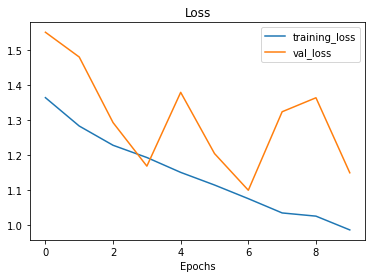

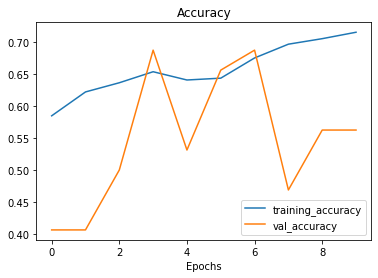

In [ ]:
plot_loss_curves(history_01)

In [ ]:
# Load in saved model weights and evaluate model
model_0.load_weights(checkpoint_path)
loaded_weights_model_results = model_0.evaluate(test_data)

6/6 [==============================] - 13s 2s/step - loss: 1.2494 - accuracy: 0.5632


# The Fine Tuning

In [ ]:
for layer in model_0.layers:
  print(layer.trainable)

True
False
True
True


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________


In [ ]:
print(len(model_0.layers[2].trainable_variables))

0


In [ ]:
base_model.trainable = False

In [ ]:
# Check which layer is trainable
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_s

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable=False

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Check which layer is trainable
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_s

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_0 = model_0.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_01.epoch[-1], # start from previous last epoch
                                               validation_steps= len(test_data),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "fine_tune")])

Saving TensorBoard log files to: transfer_learning/fine_tune/20220219-223908
Epoch 10/20
22/22 [==============================] - 88s 4s/step - loss: 1.0417 - accuracy: 0.6897 - val_loss: 1.2428 - val_accuracy: 0.5805
Epoch 11/20
22/22 [==============================] - 74s 3s/step - loss: 1.0338 - accuracy: 0.7227 - val_loss: 1.2423 - val_accuracy: 0.5747
Epoch 12/20
22/22 [==============================] - 67s 3s/step - loss: 1.0282 - accuracy: 0.7126 - val_loss: 1.2388 - val_accuracy: 0.5690
Epoch 13/20
22/22 [==============================] - 66s 3s/step - loss: 1.0382 - accuracy: 0.7055 - val_loss: 1.2364 - val_accuracy: 0.5805
Epoch 14/20
22/22 [==============================] - 66s 3s/step - loss: 1.0020 - accuracy: 0.7198 - val_loss: 1.2347 - val_accuracy: 0.5805
Epoch 15/20
22/22 [==============================] - 66s 3s/step - loss: 1.0259 - accuracy: 0.7126 - val_loss: 1.2329 - val_accuracy: 0.5747
Epoch 16/20
22/22 [==============================] - 66s 3s/step - loss: 1.00

Something is not right

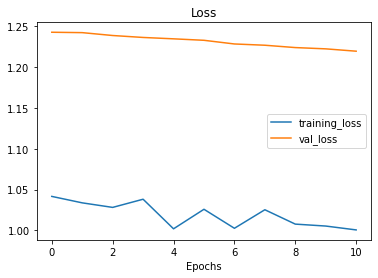

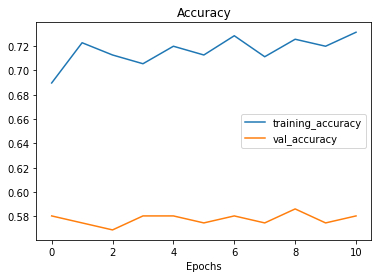

In [ ]:
plot_loss_curves(history_fine_0)

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.VGG(include_top= False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(48, 48, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(7, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_vgg = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_vgg = model_vgg.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_1")])

Shape after base_model: (None, 1, 1, 512)
After GlobalAveragePooling2D(): (None, 512)
Saving TensorBoard log files to: transfer_learning/model_vgg_1/20220220-141957
Epoch 1/5
42/42 [==============================] - 40s 939ms/step - loss: 8.7954 - accuracy: 0.2291 - val_loss: 5.7606 - val_accuracy: 0.3313
Epoch 2/5
42/42 [==============================] - 38s 917ms/step - loss: 5.0316 - accuracy: 0.3295 - val_loss: 3.5550 - val_accuracy: 0.4451
Epoch 3/5
42/42 [==============================] - 38s 914ms/step - loss: 3.4369 - accuracy: 0.4079 - val_loss: 2.5067 - val_accuracy: 0.5093
Epoch 4/5
42/42 [==============================] - 49s 1s/step - loss: 2.5347 - accuracy: 0.4528 - val_loss: 2.0119 - val_accuracy: 0.5321
Epoch 5/5
42/42 [==============================] - 49s 1s/step - loss: 2.0430 - accuracy: 0.5038 - val_loss: 1.6659 - val_accuracy: 0.5818


In [ ]:
history_vgg1 = model_vgg.fit(train_data,
                                 epochs=20,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 initial_epoch=history_vgg.epoch[-1], # start from previous last epoch
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_1")])

Saving TensorBoard log files to: transfer_learning/model_vgg_1/20220220-142610
Epoch 5/20
42/42 [==============================] - 39s 928ms/step - loss: 1.5218 - accuracy: 0.5776 - val_loss: 1.4502 - val_accuracy: 0.6066
Epoch 6/20
42/42 [==============================] - 49s 1s/step - loss: 1.3980 - accuracy: 0.6027 - val_loss: 1.2853 - val_accuracy: 0.6335
Epoch 7/20
42/42 [==============================] - 49s 1s/step - loss: 1.2789 - accuracy: 0.6233 - val_loss: 1.2019 - val_accuracy: 0.6542
Epoch 8/20
42/42 [==============================] - 49s 1s/step - loss: 1.1128 - accuracy: 0.6674 - val_loss: 1.1101 - val_accuracy: 0.6501
Epoch 9/20
42/42 [==============================] - 48s 1s/step - loss: 1.0391 - accuracy: 0.6613 - val_loss: 1.0619 - val_accuracy: 0.6729
Epoch 10/20
42/42 [==============================] - 38s 917ms/step - loss: 1.0006 - accuracy: 0.6826 - val_loss: 1.0539 - val_accuracy: 0.6708
Epoch 11/20
42/42 [==============================] - 38s 914ms/step - loss

In [ ]:
history_vgg1 = model_vgg.fit(train_data,
                                 epochs=50,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 initial_epoch=history_vgg1.epoch[-1], # start from previous last epoch
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_1")])

Saving TensorBoard log files to: transfer_learning/model_vgg_1/20220220-143858
Epoch 20/50
42/42 [==============================] - 39s 935ms/step - loss: 0.7150 - accuracy: 0.7511 - val_loss: 0.9424 - val_accuracy: 0.7329
Epoch 21/50
42/42 [==============================] - 49s 1s/step - loss: 0.6935 - accuracy: 0.7633 - val_loss: 0.8820 - val_accuracy: 0.7412
Epoch 22/50
42/42 [==============================] - 39s 924ms/step - loss: 0.6558 - accuracy: 0.7694 - val_loss: 0.8691 - val_accuracy: 0.7474
Epoch 23/50
42/42 [==============================] - 49s 1s/step - loss: 0.6288 - accuracy: 0.7945 - val_loss: 0.8382 - val_accuracy: 0.7557
Epoch 24/50
42/42 [==============================] - 39s 938ms/step - loss: 0.6300 - accuracy: 0.7694 - val_loss: 0.9011 - val_accuracy: 0.7267
Epoch 25/50
42/42 [==============================] - 39s 929ms/step - loss: 0.7210 - accuracy: 0.7466 - val_loss: 0.8830 - val_accuracy: 0.7453
Epoch 26/50
42/42 [==============================] - 39s 925ms/

In [ ]:
history_vgg1 = model_vgg.fit(train_data,
                                 epochs=51,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 initial_epoch=history_vgg1.epoch[-1], # start from previous last epoch
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_1")])

Saving TensorBoard log files to: transfer_learning/model_vgg_1/20220220-153723
Epoch 50/51
42/42 [==============================] - 51s 1s/step - loss: 0.4248 - accuracy: 0.8516 - val_loss: 1.0523 - val_accuracy: 0.7785
Epoch 51/51
42/42 [==============================] - 49s 1s/step - loss: 0.4421 - accuracy: 0.8379 - val_loss: 1.0804 - val_accuracy: 0.7578


In [ ]:
#THE CONFUSION MATRIX
#-------------------------------------------------
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
def PrettyConfusionMatrix(y_true,y_pred,classes=None,figsize=(10,10),text_size=15 ):

    cm=confusion_matrix(y_true,y_pred)
    cm_norm=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    n_classes=cm.shape[0]

    #Making prettify
    fig, ax= plt.subplots(figsize=figsize)
    # Create matrix Plot
    cax=ax.matshow(cm,cmap=plt.cm.Blues)
    fig.colorbar(cax)

    #Create clases

    if classes:
        labels=classes
    else:
        labels=np.arange(cm.shape[0])

    #axis labeling
    ax.set(title="Confusion Matrix",
          xlabel="Predicted Label",
          ylabel="True Label",
          xticks=np.arange(n_classes),
          yticks=np.arange(n_classes),
          xticklabels=labels,
          yticklabels=labels)
    #Set x axis to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    #Adjust  label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size+10)
    #set thresh hold for different Colours
    threshold= (cm.max()+cm.min())/2

    #Plot the text on each cell
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                horizontalalignment= "center",
                color="white"  if cm[i,j]>threshold else "black",
                size=15)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen_1=ImageDataGenerator()

#Load our image data from directories
test_data_1= test_datagen_1.flow_from_directory(directory= test_dir,
                                              target_size=(48,48),
                                              class_mode= "categorical",
                                              color_mode="grayscale",
                                              batch_size= 207)
images,labels= test_data_1.next()
print(labels.shape)


Found 207 images belonging to 7 classes.
(207, 7)


In [ ]:
data_prob=model_vgg.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)

In [ ]:
model_vgg.evaluate(test_data_1)

1/1 [==============================] - 10s 10s/step - loss: 1.0930 - accuracy: 0.7516


[1.092965841293335, 0.7515528202056885]

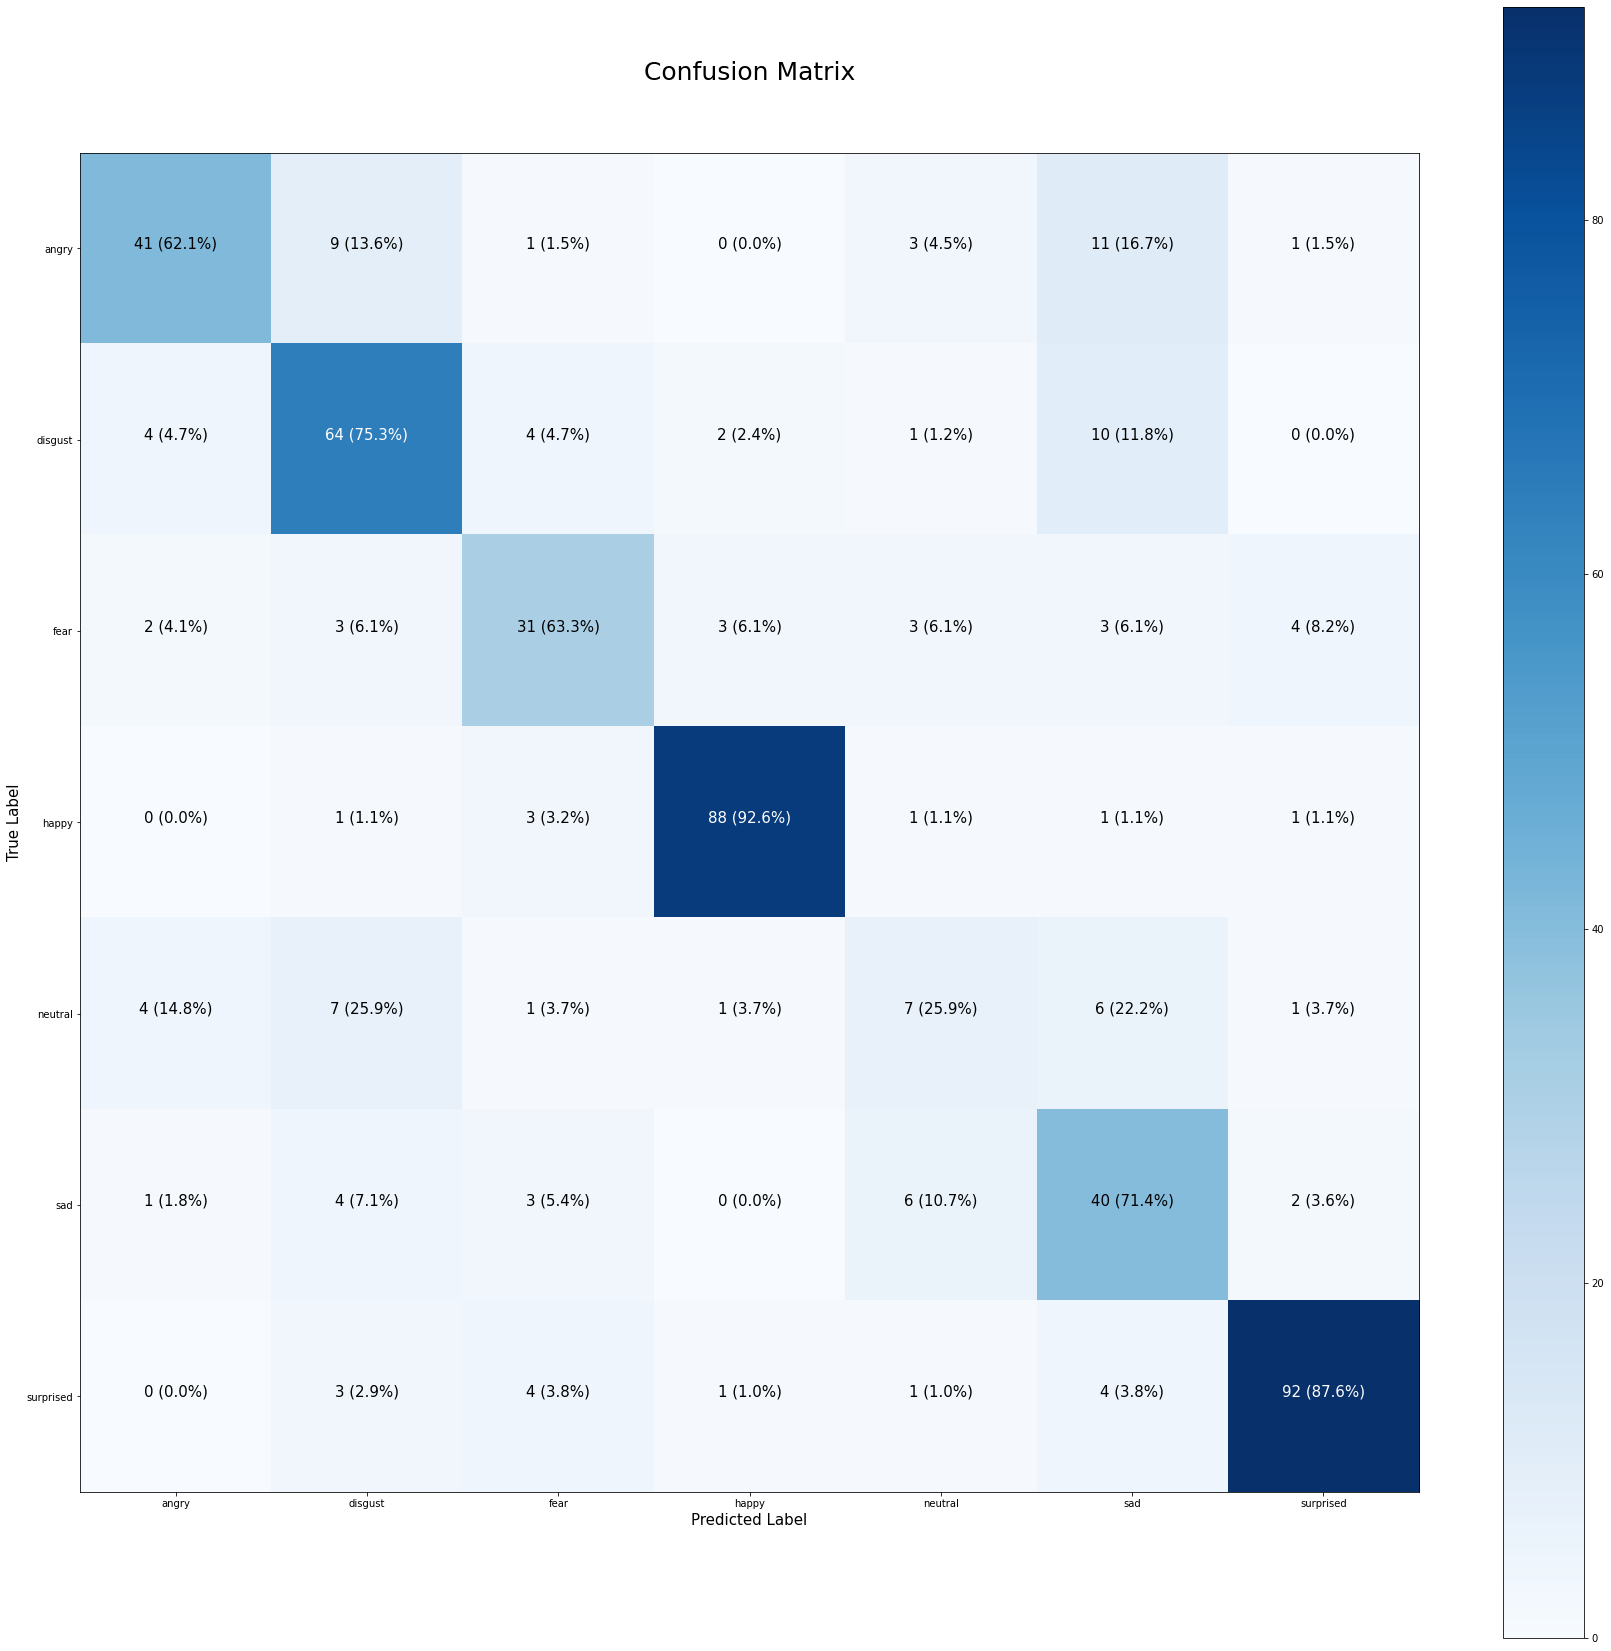

In [ ]:
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.VGG19(include_top= False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(48, 48, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(7, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_vgg19= tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_vgg19.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_vgg19 = model_vgg19.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_2")])

80150528/80134624 [==============================] - 1s 0us/step
Shape after base_model: (None, 1, 1, 512)
After GlobalAveragePooling2D(): (None, 512)
Saving TensorBoard log files to: transfer_learning/model_vgg_2/20220220-154439
Epoch 1/5
42/42 [==============================] - 56s 1s/step - loss: 20.3627 - accuracy: 0.1606 - val_loss: 9.9142 - val_accuracy: 0.2422
Epoch 2/5
42/42 [==============================] - 56s 1s/step - loss: 8.3367 - accuracy: 0.2755 - val_loss: 6.0286 - val_accuracy: 0.3602
Epoch 3/5
42/42 [==============================] - 55s 1s/step - loss: 5.5429 - accuracy: 0.3569 - val_loss: 4.5720 - val_accuracy: 0.3996
Epoch 4/5
42/42 [==============================] - 48s 1s/step - loss: 4.2758 - accuracy: 0.4079 - val_loss: 3.8690 - val_accuracy: 0.4576
Epoch 5/5
42/42 [==============================] - 52s 1s/step - loss: 3.5259 - accuracy: 0.4376 - val_loss: 3.3149 - val_accuracy: 0.4513


In [ ]:
history_vgg1 = model_vgg.fit(train_data,
                                 epochs=30,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 initial_epoch=history_vgg1.epoch[-1], # start from previous last epoch
                                 validation_steps=len(test_data), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model_vgg_1")])

In [ ]:
#Easy model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPool2D,BatchNormalization, Activation, AveragePooling2D,Dropout
from tensorflow.keras import Sequential

In [ ]:
from gc import callbacks
model_14= Sequential([
    Conv2D(filters=24, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,3, activation="relu"),
    MaxPool2D(),
    Conv2D(24,3, activation="relu"),
    Conv2D(24,3, activation="relu"),
    MaxPool2D(),
    Conv2D(24,3, activation="relu"),
    Conv2D(24,3, activation="tanh"),
    MaxPool2D(),
    Flatten(),
    Dense(40, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_14.compile(loss= "categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"],
                )

#fit the model
history_14=model_14.fit(
    train_data,
    epochs=22,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/22
33/33 [==============================] - 7s 188ms/step - loss: 1.8487 - accuracy: 0.2533 - val_loss: 1.7927 - val_accuracy: 0.3527
Epoch 2/22
33/33 [==============================] - 6s 179ms/step - loss: 1.3836 - accuracy: 0.5038 - val_loss: 1.4330 - val_accuracy: 0.4879
Epoch 3/22
33/33 [==============================] - 6s 181ms/step - loss: 1.0478 - accuracy: 0.6267 - val_loss: 1.3956 - val_accuracy: 0.5024
Epoch 4/22
33/33 [==============================] - 6s 175ms/step - loss: 0.9236 - accuracy: 0.6676 - val_loss: 1.1739 - val_accuracy: 0.5749
Epoch 5/22
33/33 [==============================] - 6s 195ms/step - loss: 0.8466 - accuracy: 0.6914 - val_loss: 0.9136 - val_accuracy: 0.6763
Epoch 6/22
33/33 [==============================] - 6s 177ms/step - loss: 0.6673 - accuracy: 0.7648 - val_loss: 0.9394 - val_accuracy: 0.6425
Epoch 7/22
33/33 [==============================] - 6s 177ms/step - loss: 0.5787 - accuracy: 0.8133 - val_loss: 0.8797 - val_accuracy: 0.6667
Epoch 

In [ ]:
model_17.save("model_17_84.h5")

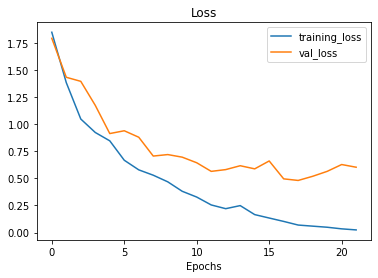

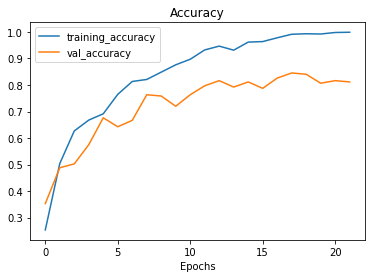

In [ ]:
plot_loss_curves(history_14)

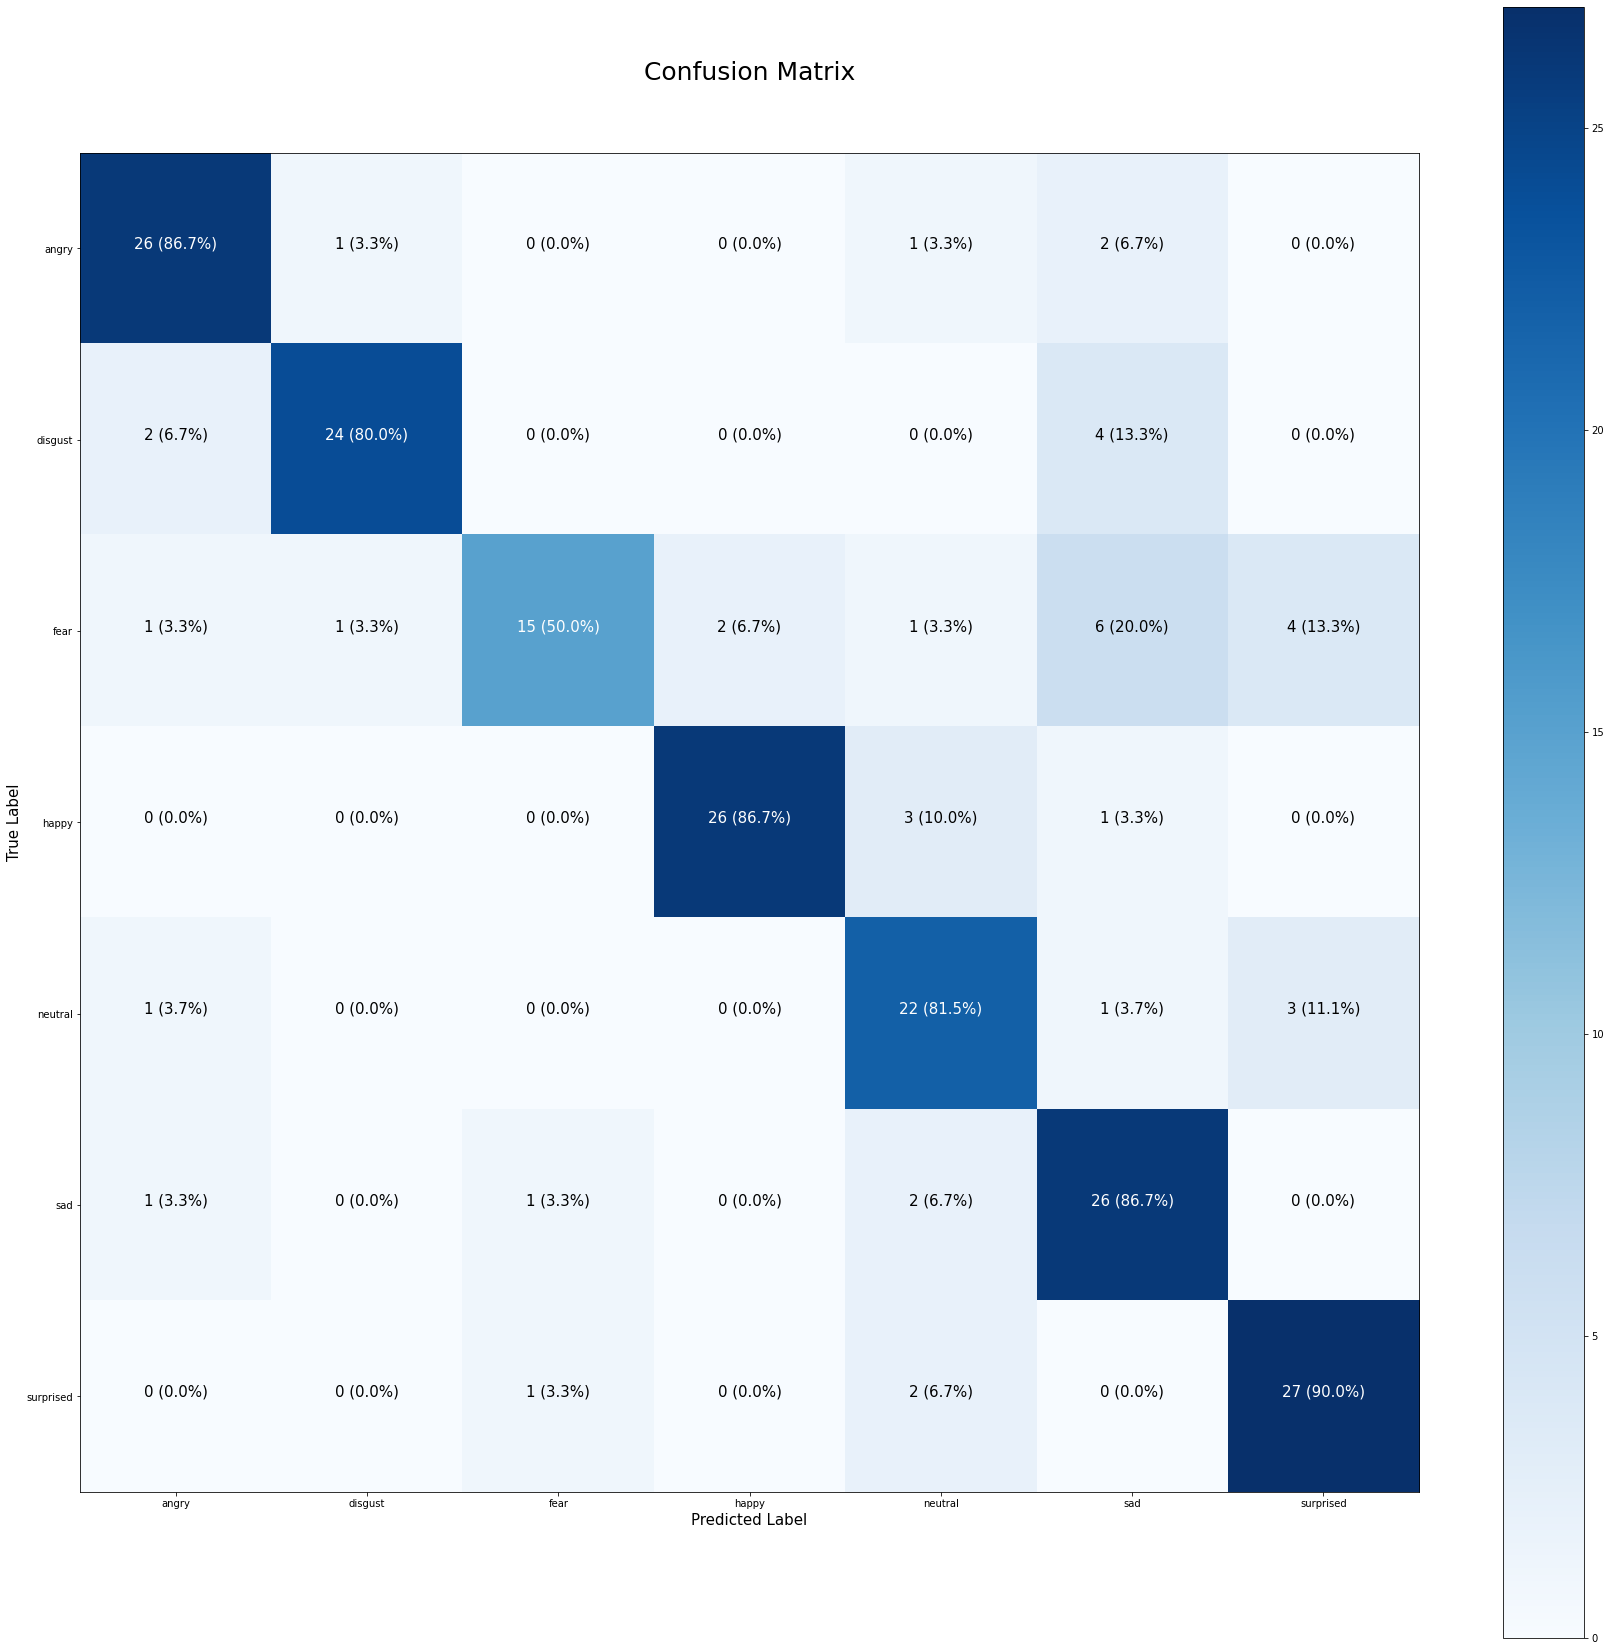

In [ ]:
data_prob=model_14.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
from gc import callbacks
model_15= Sequential([
    Conv2D(filters=10, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Flatten(),
    Dense(40, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_15.compile(loss= "categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"],
                )

#fit the model
history_15=model_15.fit(
    train_data,
    epochs=22,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/22
33/33 [==============================] - 6s 140ms/step - loss: 2.1051 - accuracy: 0.1476 - val_loss: 1.9529 - val_accuracy: 0.1449
Epoch 2/22
33/33 [==============================] - 5s 136ms/step - loss: 1.9299 - accuracy: 0.1524 - val_loss: 1.9472 - val_accuracy: 0.1498
Epoch 3/22
33/33 [==============================] - 5s 136ms/step - loss: 1.9119 - accuracy: 0.1905 - val_loss: 1.9434 - val_accuracy: 0.1498
Epoch 4/22
33/33 [==============================] - 4s 130ms/step - loss: 1.8857 - accuracy: 0.2190 - val_loss: 1.9360 - val_accuracy: 0.1836
Epoch 5/22
33/33 [==============================] - 4s 131ms/step - loss: 1.8432 - accuracy: 0.2943 - val_loss: 1.9142 - val_accuracy: 0.2077
Epoch 6/22
33/33 [==============================] - 4s 128ms/step - loss: 1.7445 - accuracy: 0.3381 - val_loss: 1.8493 - val_accuracy: 0.3865
Epoch 7/22
33/33 [==============================] - 4s 129ms/step - loss: 1.6059 - accuracy: 0.3810 - val_loss: 1.7960 - val_accuracy: 0.3816
Epoch 

In [ ]:
#fit the model
history_15=model_15.fit(
    train_data,
    epochs=70,
     initial_epoch=history_15.epoch[-1], # start from previous last epoch
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 22/70
33/33 [==============================] - 5s 158ms/step - loss: 0.8640 - accuracy: 0.6876 - val_loss: 1.2832 - val_accuracy: 0.5845
Epoch 23/70
33/33 [==============================] - 4s 129ms/step - loss: 0.8881 - accuracy: 0.6695 - val_loss: 1.2463 - val_accuracy: 0.6329
Epoch 24/70
33/33 [==============================] - 4s 130ms/step - loss: 0.8385 - accuracy: 0.6905 - val_loss: 1.3006 - val_accuracy: 0.6860
Epoch 25/70
33/33 [==============================] - 4s 129ms/step - loss: 0.8830 - accuracy: 0.6676 - val_loss: 1.2733 - val_accuracy: 0.6473
Epoch 26/70
33/33 [==============================] - 4s 130ms/step - loss: 0.8462 - accuracy: 0.6981 - val_loss: 1.3346 - val_accuracy: 0.6425
Epoch 27/70
33/33 [==============================] - 5s 144ms/step - loss: 0.8097 - accuracy: 0.7076 - val_loss: 1.2919 - val_accuracy: 0.6957
Epoch 28/70
33/33 [==============================] - 4s 129ms/step - loss: 0.7940 - accuracy: 0.7029 - val_loss: 1.2300 - val_accuracy: 0.6860

In [ ]:
#fit the model
history_15=model_15.fit(
    train_data,
    epochs=100,
     initial_epoch=history_15.epoch[-1], # start from previous last epoch
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 70/100
33/33 [==============================] - 5s 133ms/step - loss: 0.5211 - accuracy: 0.7981 - val_loss: 0.9348 - val_accuracy: 0.8116
Epoch 71/100
33/33 [==============================] - 4s 130ms/step - loss: 0.5109 - accuracy: 0.8152 - val_loss: 0.9077 - val_accuracy: 0.8261
Epoch 72/100
33/33 [==============================] - 4s 131ms/step - loss: 0.5117 - accuracy: 0.8133 - val_loss: 0.8665 - val_accuracy: 0.8454
Epoch 73/100
33/33 [==============================] - 4s 132ms/step - loss: 0.5056 - accuracy: 0.8229 - val_loss: 0.9653 - val_accuracy: 0.7295
Epoch 74/100
33/33 [==============================] - 4s 131ms/step - loss: 0.5204 - accuracy: 0.8219 - val_loss: 0.8172 - val_accuracy: 0.8213
Epoch 75/100
33/33 [==============================] - 4s 131ms/step - loss: 0.5098 - accuracy: 0.8133 - val_loss: 0.8790 - val_accuracy: 0.8406
Epoch 76/100
33/33 [==============================] - 4s 132ms/step - loss: 0.5273 - accuracy: 0.7962 - val_loss: 0.9294 - val_accuracy:

In [ ]:
#fit the model
history_15=model_15.fit(
    train_data,
    epochs=150,
     initial_epoch=history_15.epoch[-1], # start from previous last epoch
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 100/150
33/33 [==============================] - 5s 158ms/step - loss: 0.4149 - accuracy: 0.8495 - val_loss: 0.7790 - val_accuracy: 0.8164
Epoch 101/150
33/33 [==============================] - 4s 130ms/step - loss: 0.4270 - accuracy: 0.8371 - val_loss: 0.8168 - val_accuracy: 0.8068
Epoch 102/150
33/33 [==============================] - 4s 130ms/step - loss: 0.4064 - accuracy: 0.8495 - val_loss: 0.8162 - val_accuracy: 0.8213
Epoch 103/150
33/33 [==============================] - 4s 128ms/step - loss: 0.3856 - accuracy: 0.8514 - val_loss: 0.7289 - val_accuracy: 0.8406
Epoch 104/150
33/33 [==============================] - 4s 131ms/step - loss: 0.4302 - accuracy: 0.8362 - val_loss: 0.7280 - val_accuracy: 0.8116
Epoch 105/150
33/33 [==============================] - 4s 131ms/step - loss: 0.4191 - accuracy: 0.8476 - val_loss: 0.7601 - val_accuracy: 0.8019
Epoch 106/150
33/33 [==============================] - 4s 131ms/step - loss: 0.3860 - accuracy: 0.8648 - val_loss: 0.8339 - val_ac

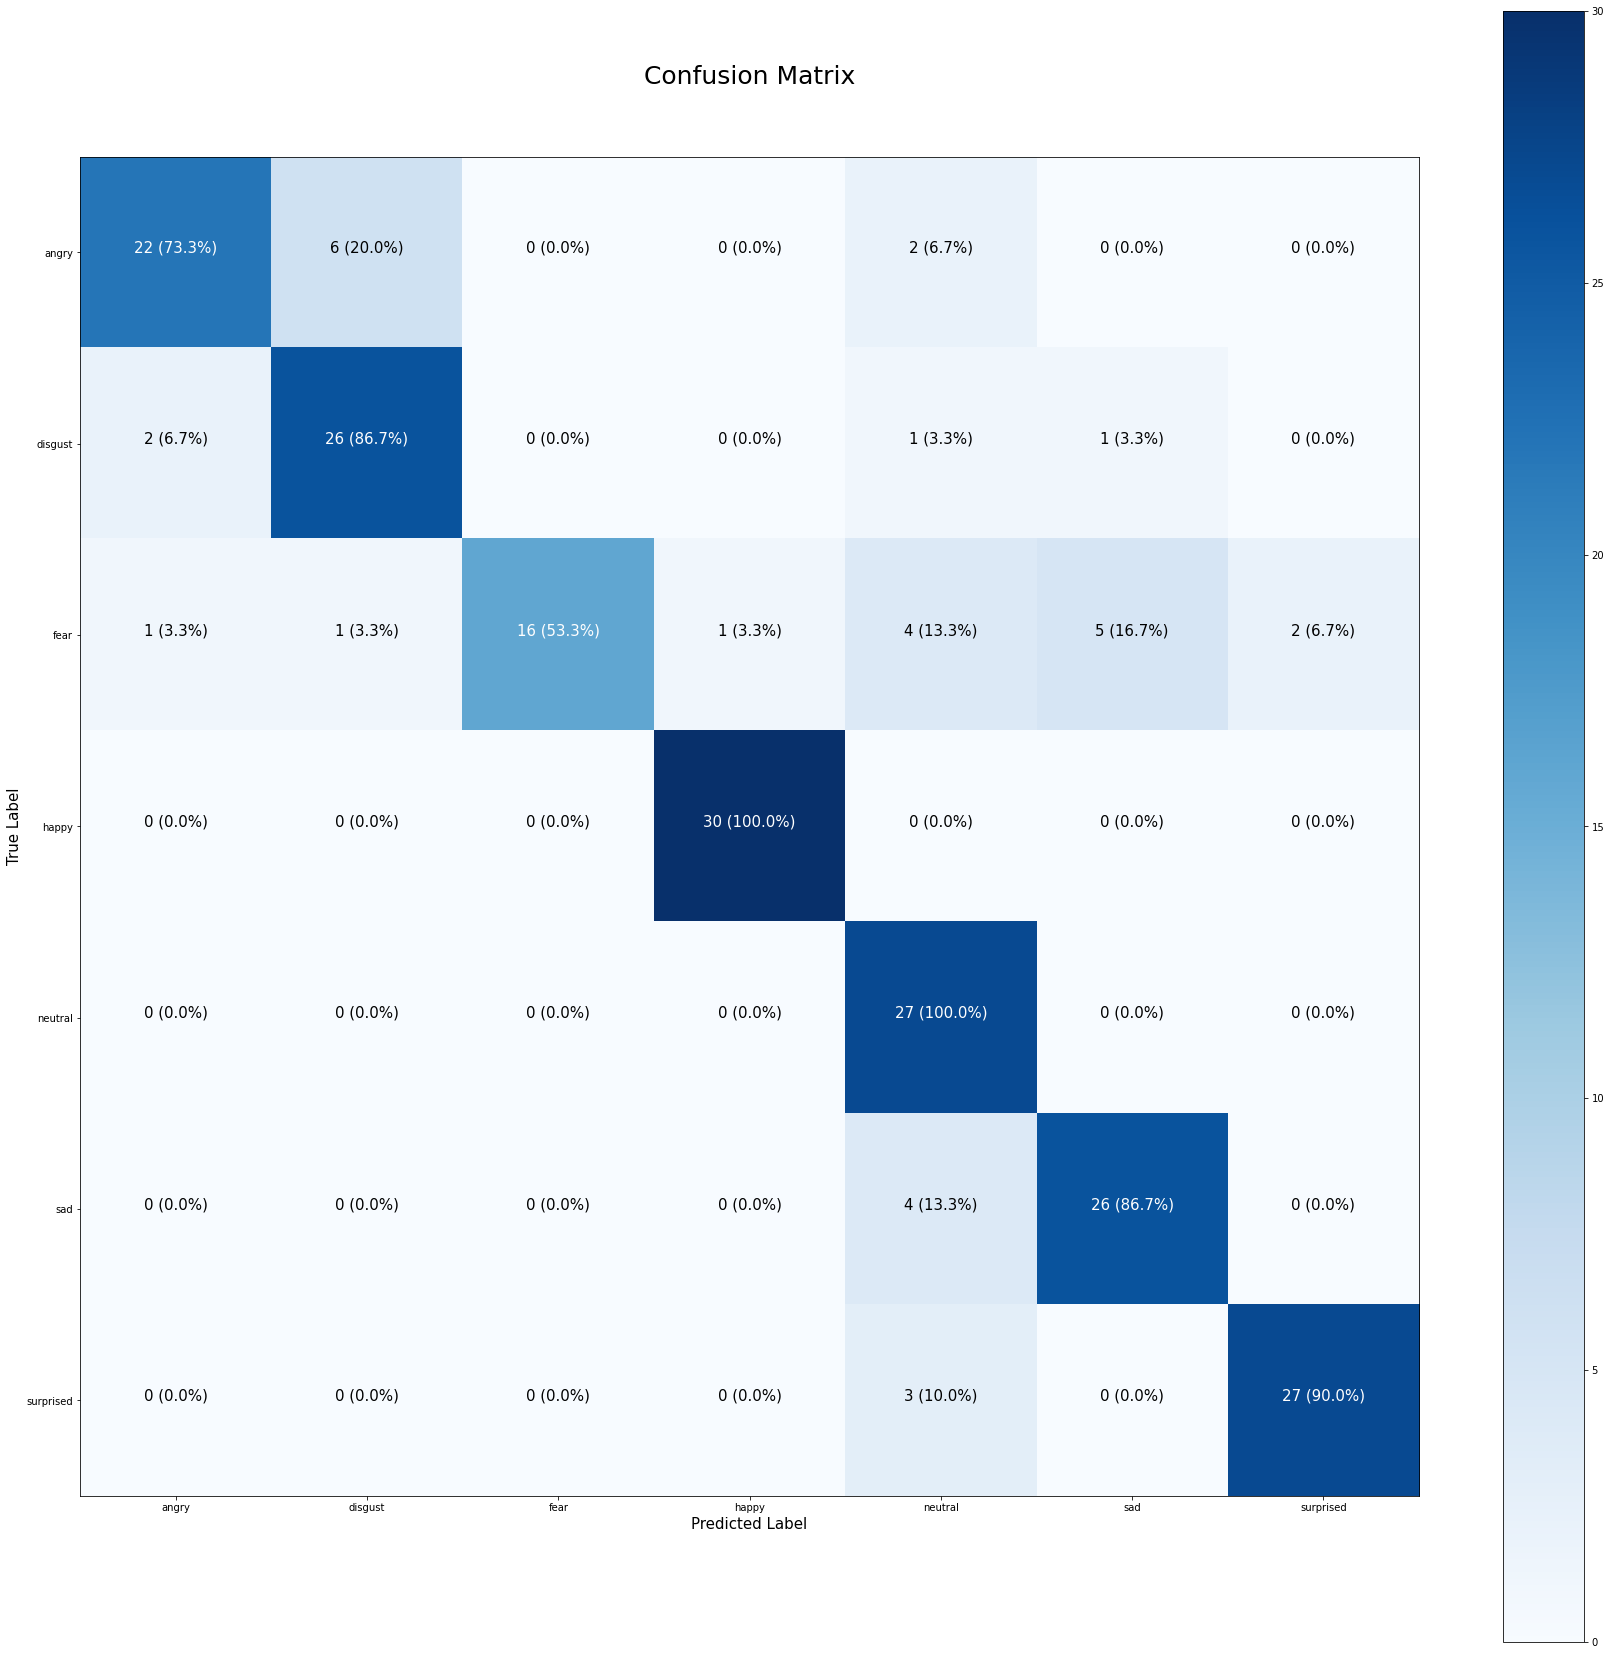

In [ ]:

data_prob=model_15.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
from gc import callbacks
model_16= Sequential([
    Conv2D(filters=32, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,3, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Flatten(),
    Dense(40, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_16.compile(loss= "categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"],
                )

#fit the model
history_16=model_16.fit(
    train_data,
    epochs=200,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/200
33/33 [==============================] - 9s 234ms/step - loss: 2.1270 - accuracy: 0.1724 - val_loss: 1.9458 - val_accuracy: 0.1449
Epoch 2/200
33/33 [==============================] - 7s 221ms/step - loss: 1.9372 - accuracy: 0.1943 - val_loss: 1.9434 - val_accuracy: 0.1884
Epoch 3/200
33/33 [==============================] - 7s 222ms/step - loss: 1.8831 - accuracy: 0.2486 - val_loss: 1.9124 - val_accuracy: 0.2464
Epoch 4/200
33/33 [==============================] - 7s 221ms/step - loss: 1.7432 - accuracy: 0.3124 - val_loss: 1.8467 - val_accuracy: 0.3092
Epoch 5/200
33/33 [==============================] - 7s 221ms/step - loss: 1.6573 - accuracy: 0.3448 - val_loss: 1.7860 - val_accuracy: 0.2754
Epoch 6/200
33/33 [==============================] - 7s 222ms/step - loss: 1.5710 - accuracy: 0.4057 - val_loss: 1.7515 - val_accuracy: 0.3285
Epoch 7/200
33/33 [==============================] - 7s 221ms/step - loss: 1.5280 - accuracy: 0.4105 - val_loss: 1.7329 - val_accuracy: 0.4251

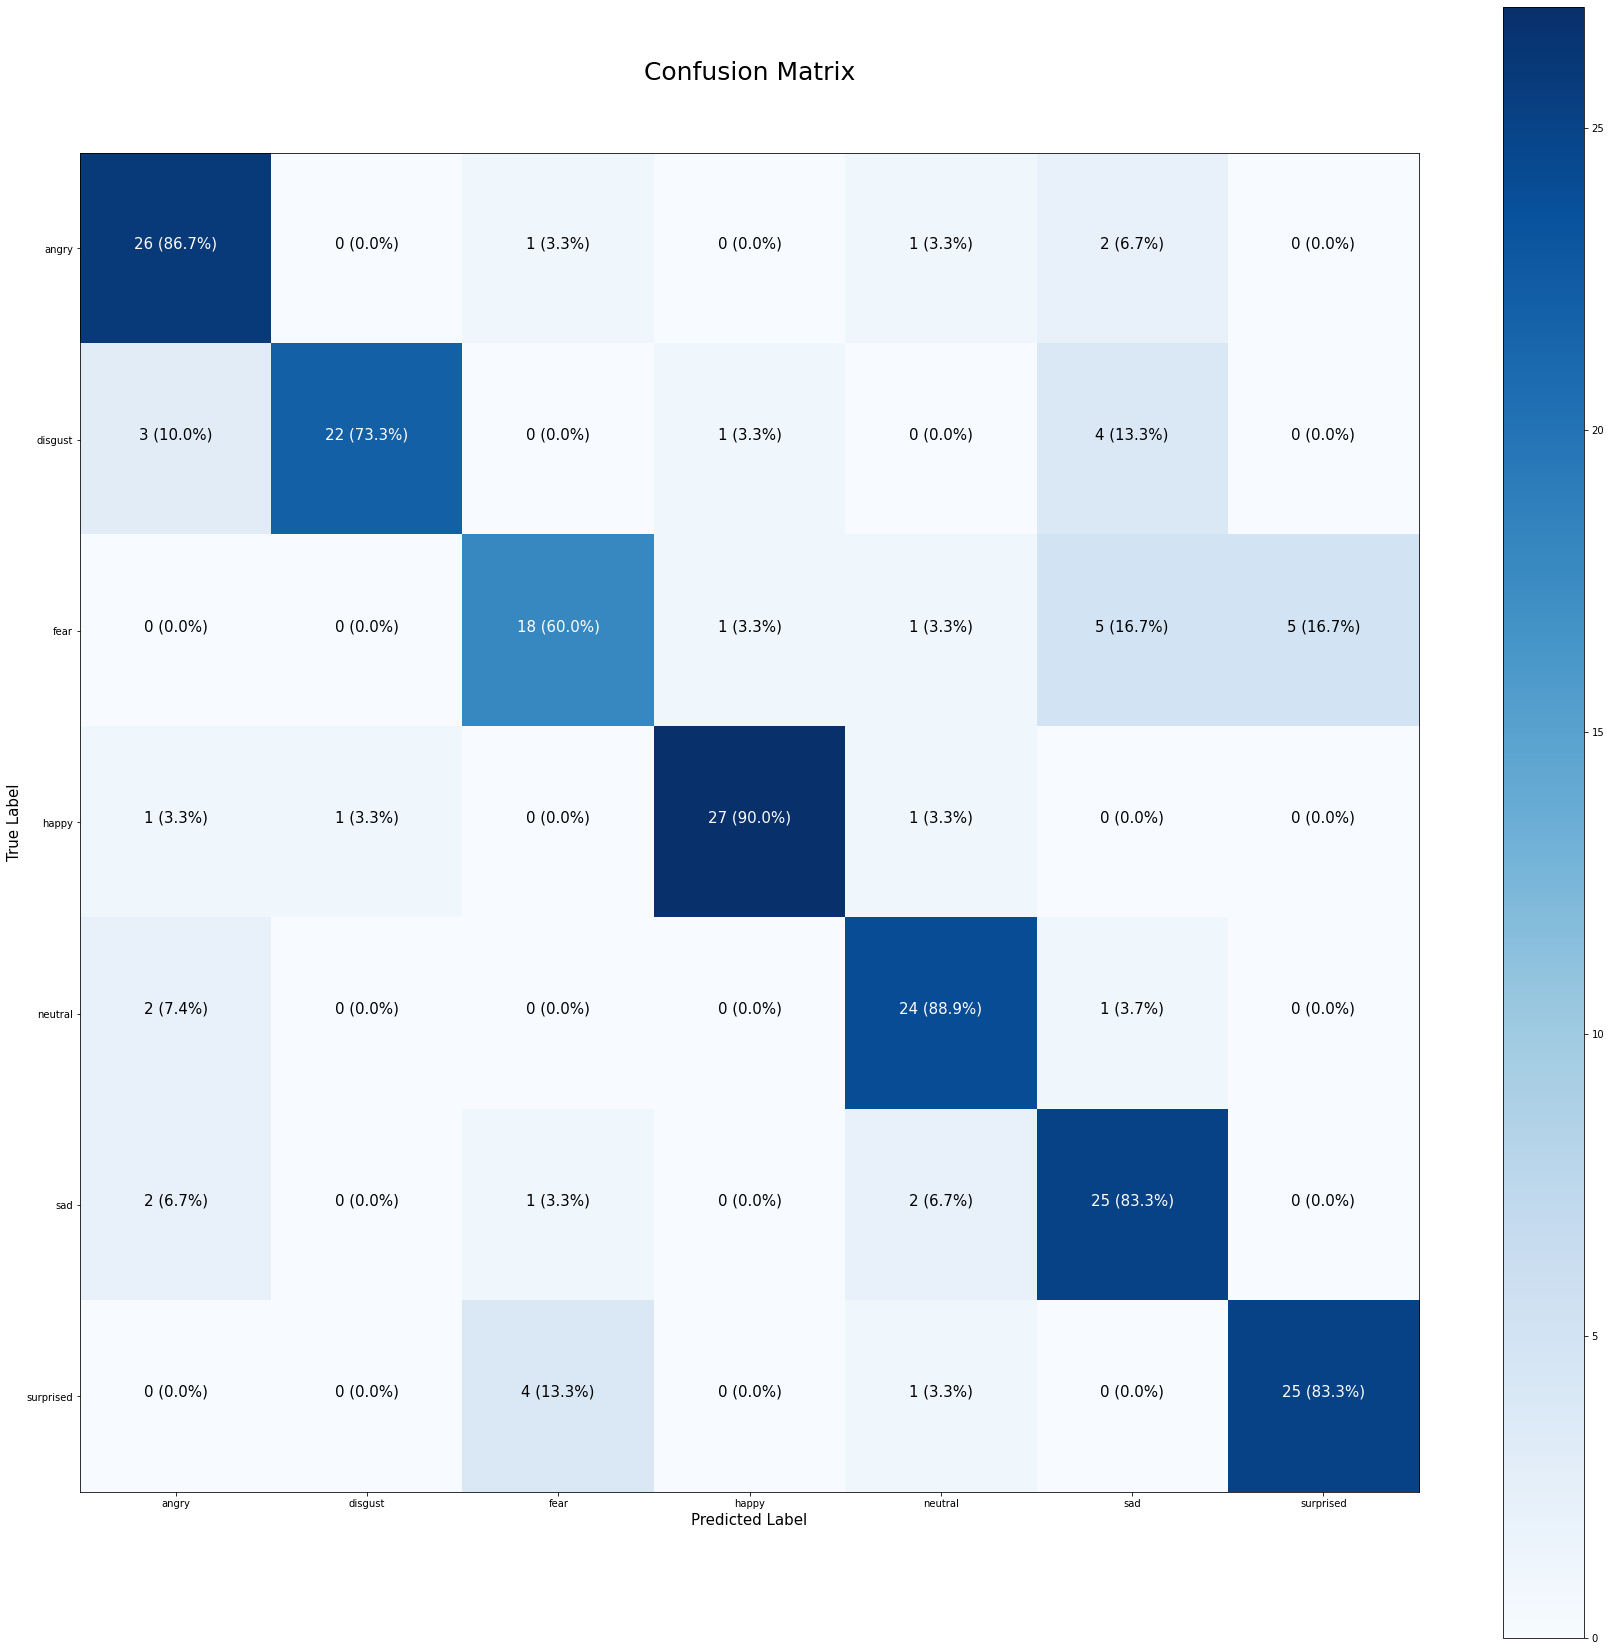

In [ ]:

data_prob=model_16.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
from gc import callbacks
model_17= Sequential([
    Conv2D(filters=20, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,3, activation="relu"),
    Conv2D(24,3, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(24,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Flatten(),
    Dense(500, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_17.compile(loss= "categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"],
                )

#fit the model
history_17=model_17.fit(
    train_data,
    epochs=200,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/200
33/33 [==============================] - 7s 178ms/step - loss: 2.0162 - accuracy: 0.1838 - val_loss: 1.9307 - val_accuracy: 0.1981
Epoch 2/200
33/33 [==============================] - 6s 167ms/step - loss: 1.8082 - accuracy: 0.2905 - val_loss: 1.8305 - val_accuracy: 0.3188
Epoch 3/200
33/33 [==============================] - 6s 169ms/step - loss: 1.5749 - accuracy: 0.3990 - val_loss: 1.7429 - val_accuracy: 0.3768
Epoch 4/200
33/33 [==============================] - 6s 170ms/step - loss: 1.3360 - accuracy: 0.4905 - val_loss: 1.7787 - val_accuracy: 0.3816
Epoch 5/200
33/33 [==============================] - 6s 169ms/step - loss: 1.1785 - accuracy: 0.5714 - val_loss: 1.5162 - val_accuracy: 0.5700
Epoch 6/200
33/33 [==============================] - 6s 168ms/step - loss: 1.0737 - accuracy: 0.6086 - val_loss: 1.4967 - val_accuracy: 0.6329
Epoch 7/200
33/33 [==============================] - 6s 168ms/step - loss: 1.0290 - accuracy: 0.6248 - val_loss: 1.4666 - val_accuracy: 0.6522

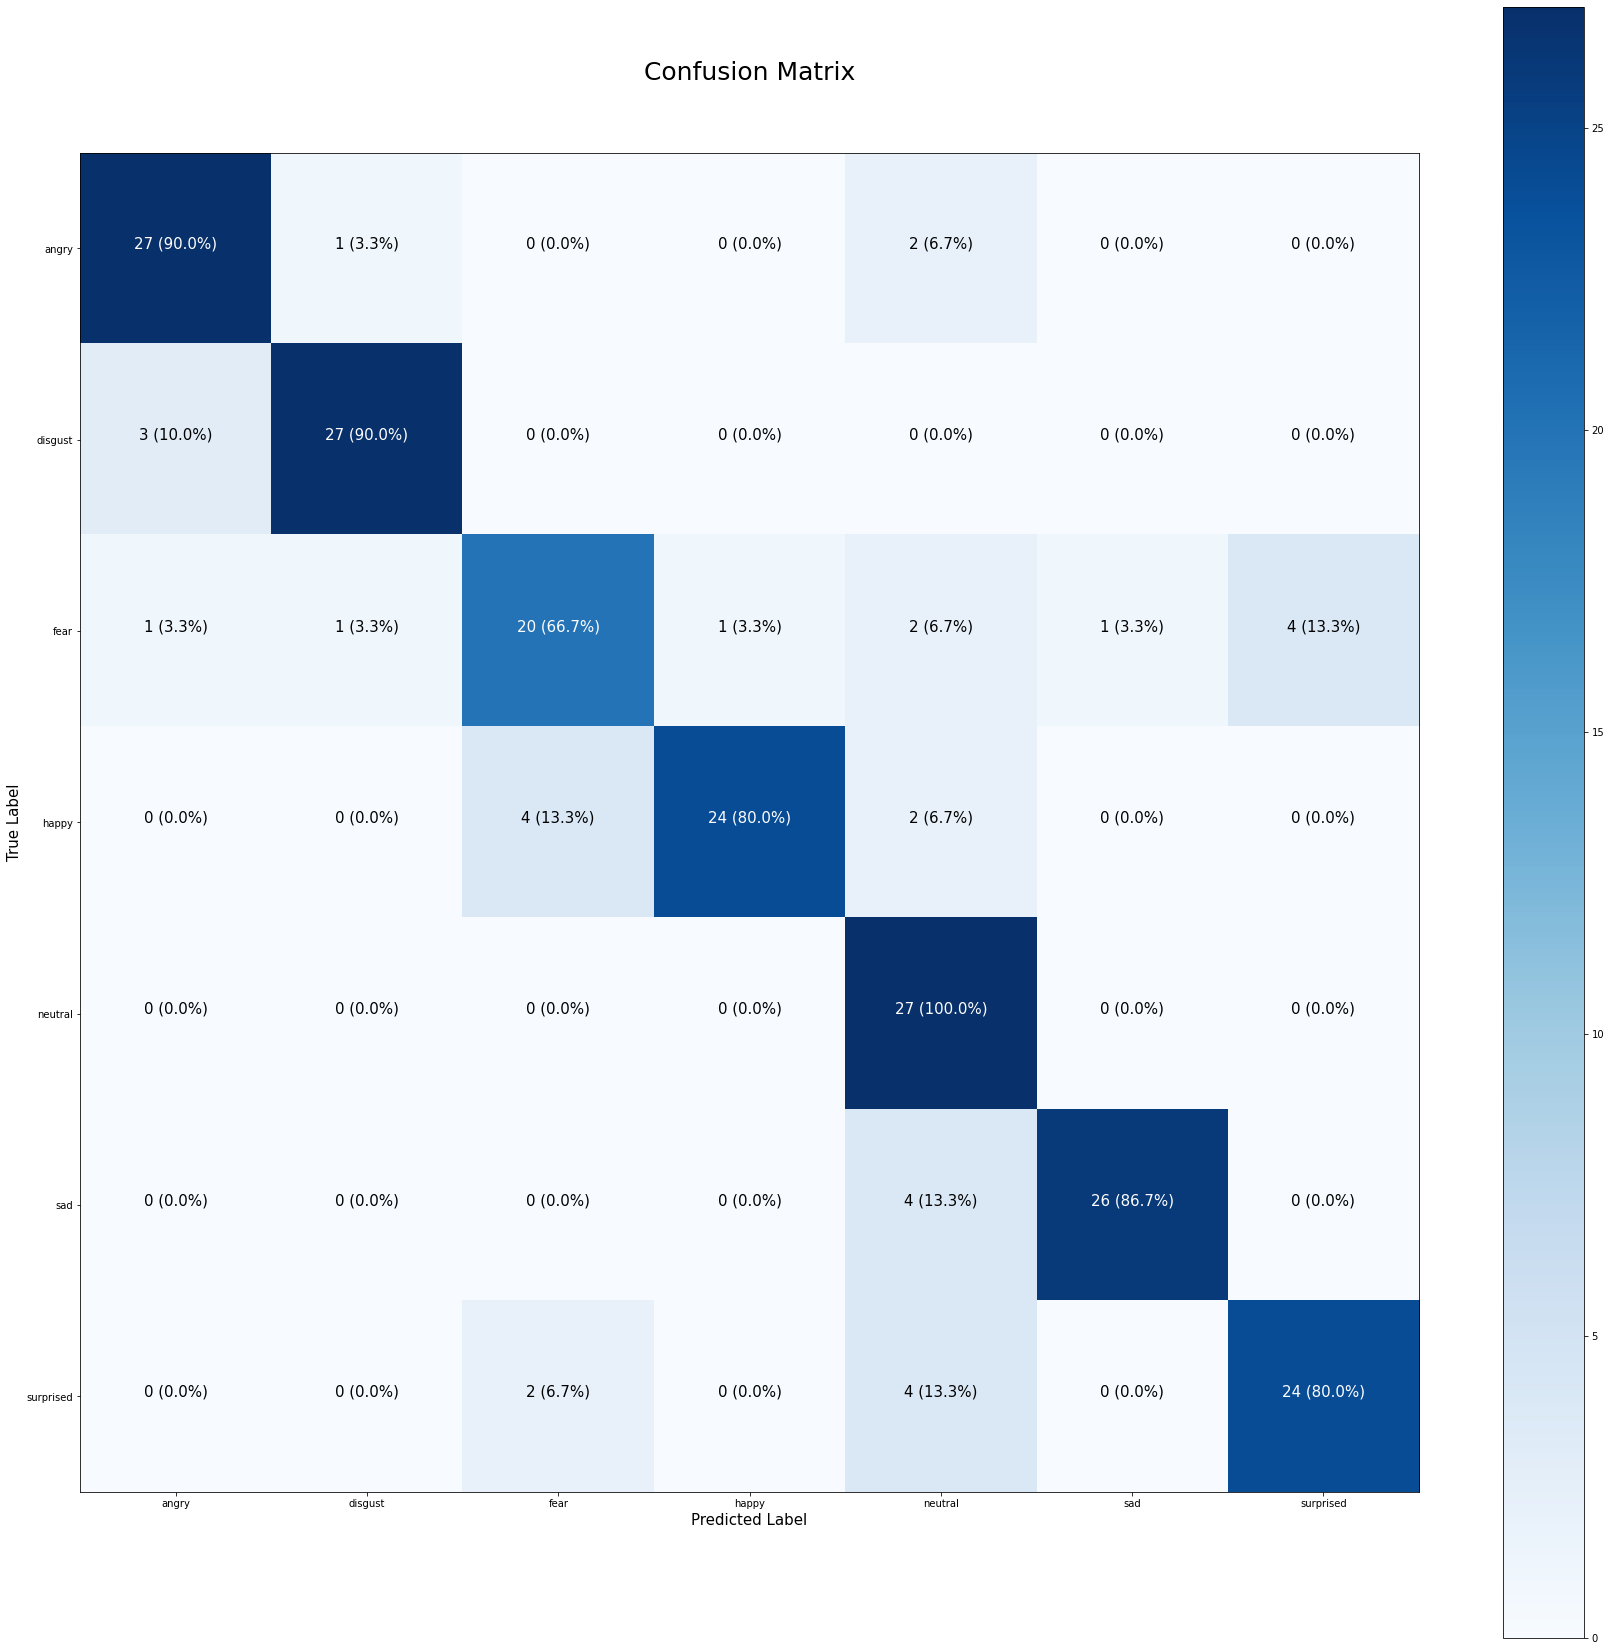

In [ ]:
data_prob=model_17.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

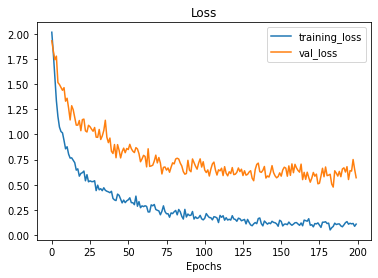

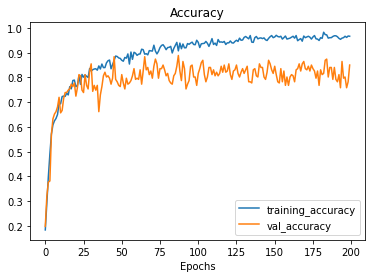

In [ ]:
plot_loss_curves(history_17)

In [ ]:
from gc import callbacks
model_17= Sequential([
    Conv2D(filters=32, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(32,2, activation="relu"),
    Conv2D(32,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Conv2D(64,2, activation="relu"),
    Conv2D(64,2, activation="relu"),
    Dropout(0.5),
    MaxPool2D(),
    Flatten(),
    Dense(50, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_17.compile(loss= "categorical_crossentropy",
                optimizer=Adam(lr=0.001),
                metrics=["accuracy"],
                )

#fit the model
history_17=model_17.fit(
    train_data,
    epochs=200,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 8s 204ms/step - loss: 1.9881 - accuracy: 0.2057 - val_loss: 1.9448 - val_accuracy: 0.1449
Epoch 2/200
33/33 [==============================] - 7s 197ms/step - loss: 1.7937 - accuracy: 0.2981 - val_loss: 1.8639 - val_accuracy: 0.3188
Epoch 3/200
33/33 [==============================] - 6s 189ms/step - loss: 1.5973 - accuracy: 0.4057 - val_loss: 1.7841 - val_accuracy: 0.4106
Epoch 4/200
33/33 [==============================] - 6s 191ms/step - loss: 1.4039 - accuracy: 0.4771 - val_loss: 1.7664 - val_accuracy: 0.4396
Epoch 5/200
33/33 [==============================] - 6s 190ms/step - loss: 1.2877 - accuracy: 0.5286 - val_loss: 1.7138 - val_accuracy: 0.4831
Epoch 6/200
33/33 [==============================] - 6s 191ms/step - loss: 1.1731 - accuracy: 0.5590 - val_loss: 1.6454 - val_accuracy: 0.5652
Epoch 7/200
33/33 [==============================] - 6s 191ms/step - loss: 1.1576 - accuracy: 0.5552 - val_loss: 1.7833 - val_accuracy: 0.3623
Epoch 8/200

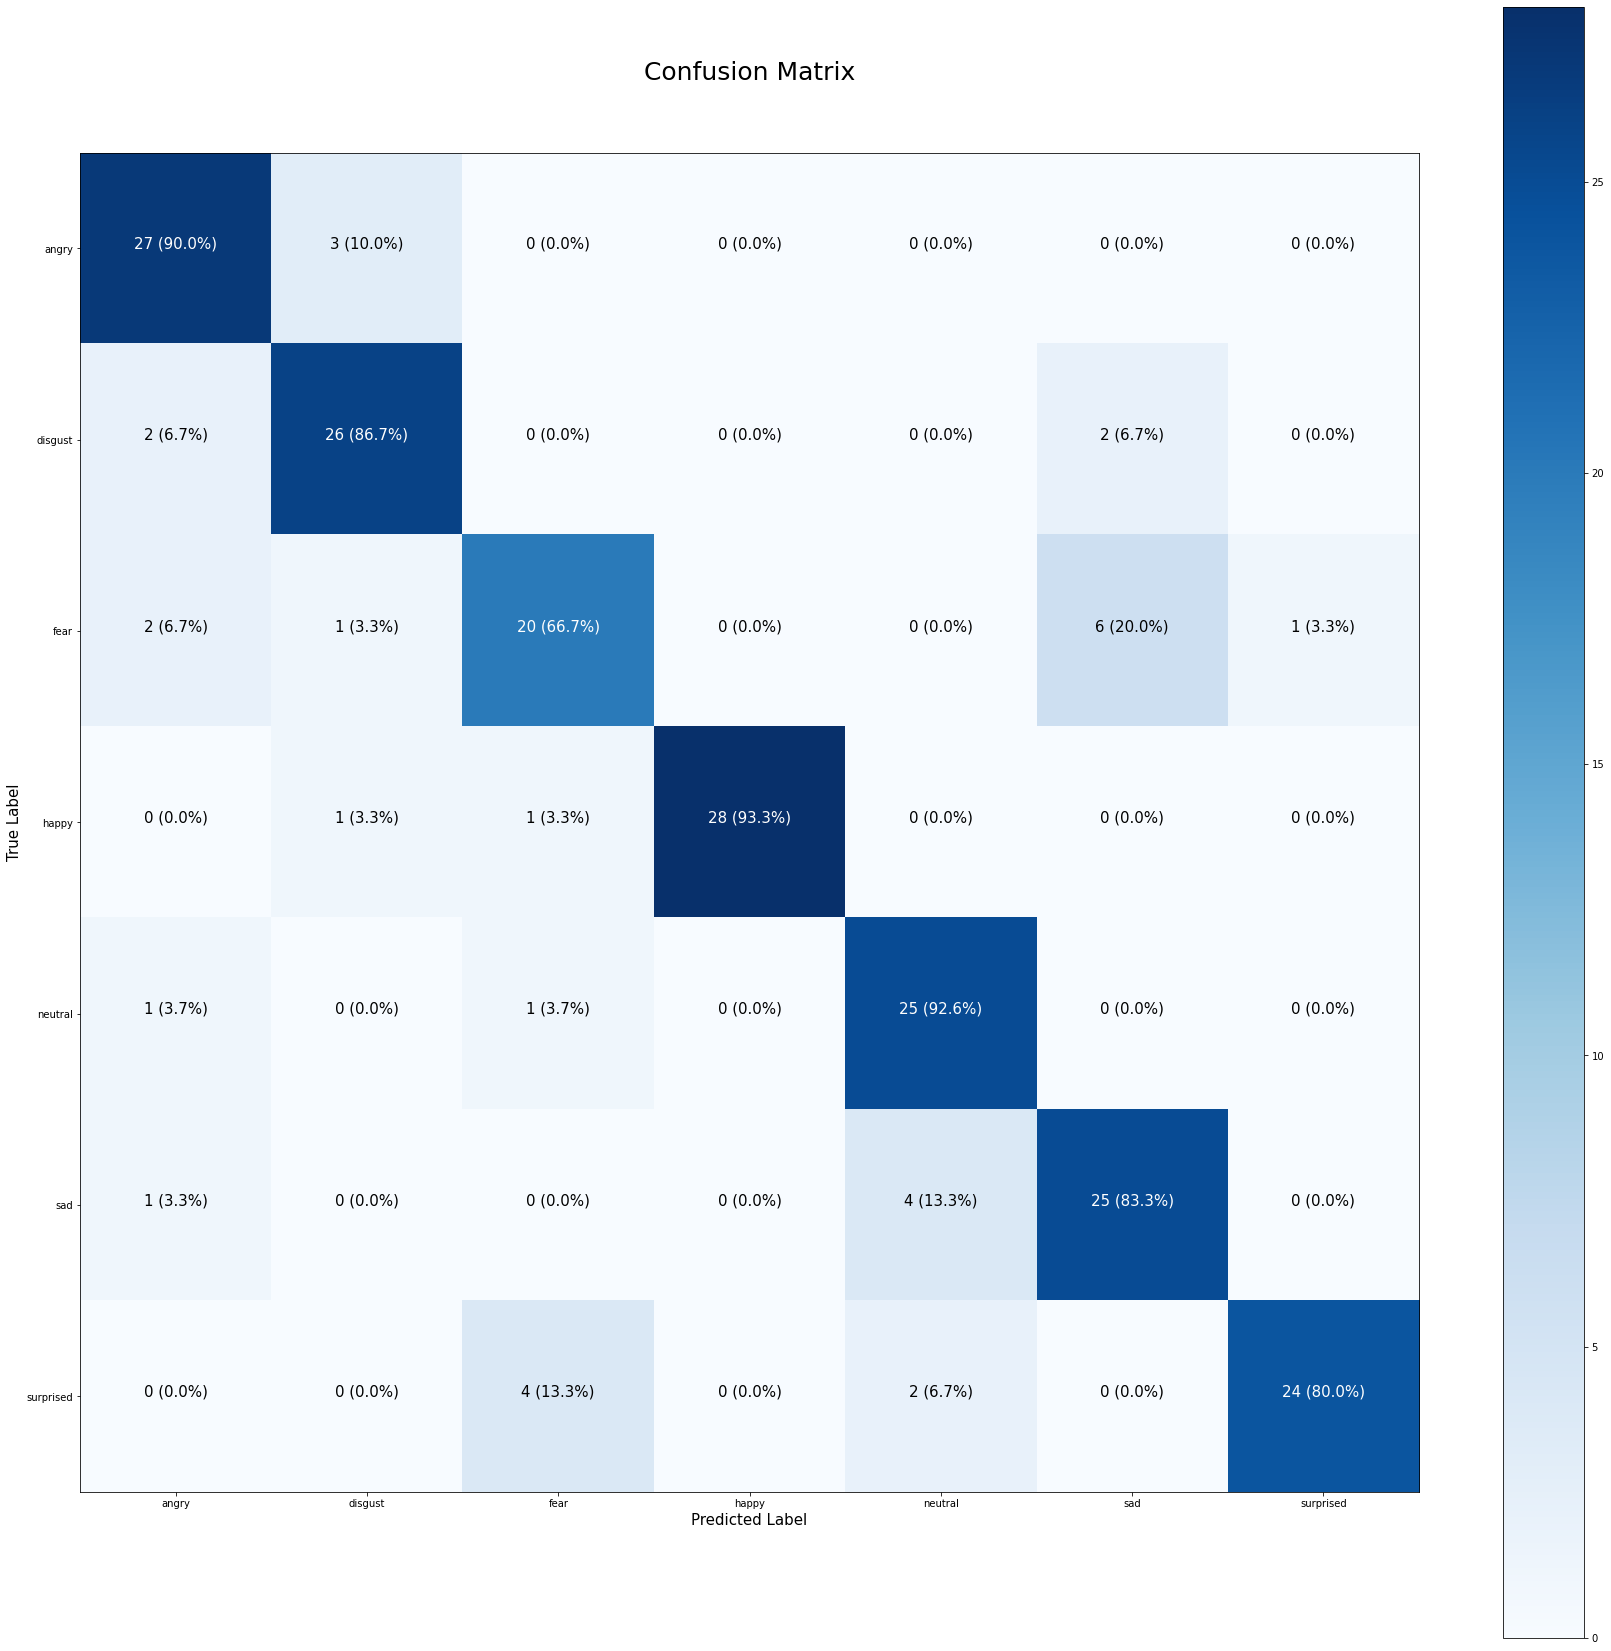

In [ ]:
data_prob=model_17.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
from gc import callbacks
model_18= Sequential([
    Conv2D(filters=32, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(24,2, activation="relu"),
    MaxPool2D(),
    Conv2D(32,2, activation="relu"),
    Conv2D(32,2, activation="relu"),
    Dropout(0.2),
    MaxPool2D(),
    Conv2D(64,2, activation="relu"),
    Conv2D(24,2, activation="relu"),
    Dropout(0.25),
    MaxPool2D(),
    Flatten(),
    Dense(20, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_18.compile(loss= "categorical_crossentropy",
                optimizer=Adam(lr=0.001),
                metrics=["accuracy"],
                )

#fit the model
history_18=model_18.fit(
    train_data,
    epochs=200,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 7s 173ms/step - loss: 1.9011 - accuracy: 0.2429 - val_loss: 1.8887 - val_accuracy: 0.2995
Epoch 2/200
33/33 [==============================] - 6s 169ms/step - loss: 1.6419 - accuracy: 0.3752 - val_loss: 1.6761 - val_accuracy: 0.3285
Epoch 3/200
33/33 [==============================] - 6s 166ms/step - loss: 1.4351 - accuracy: 0.4419 - val_loss: 1.4847 - val_accuracy: 0.4928
Epoch 4/200
33/33 [==============================] - 6s 168ms/step - loss: 1.2815 - accuracy: 0.5095 - val_loss: 1.3084 - val_accuracy: 0.5266
Epoch 5/200
33/33 [==============================] - 6s 168ms/step - loss: 1.1160 - accuracy: 0.6000 - val_loss: 1.2439 - val_accuracy: 0.4734
Epoch 6/200
33/33 [==============================] - 6s 168ms/step - loss: 1.0416 - accuracy: 0.6124 - val_loss: 1.1129 - val_accuracy: 0.5942
Epoch 7/200
33/33 [==============================] - 6s 167ms/step - loss: 0.9472 - accuracy: 0.6533 - val_loss: 1.0164 - val_accuracy: 0.6280
Epoch 8/200

In [ ]:
model_17.save("model_19_81.h5")

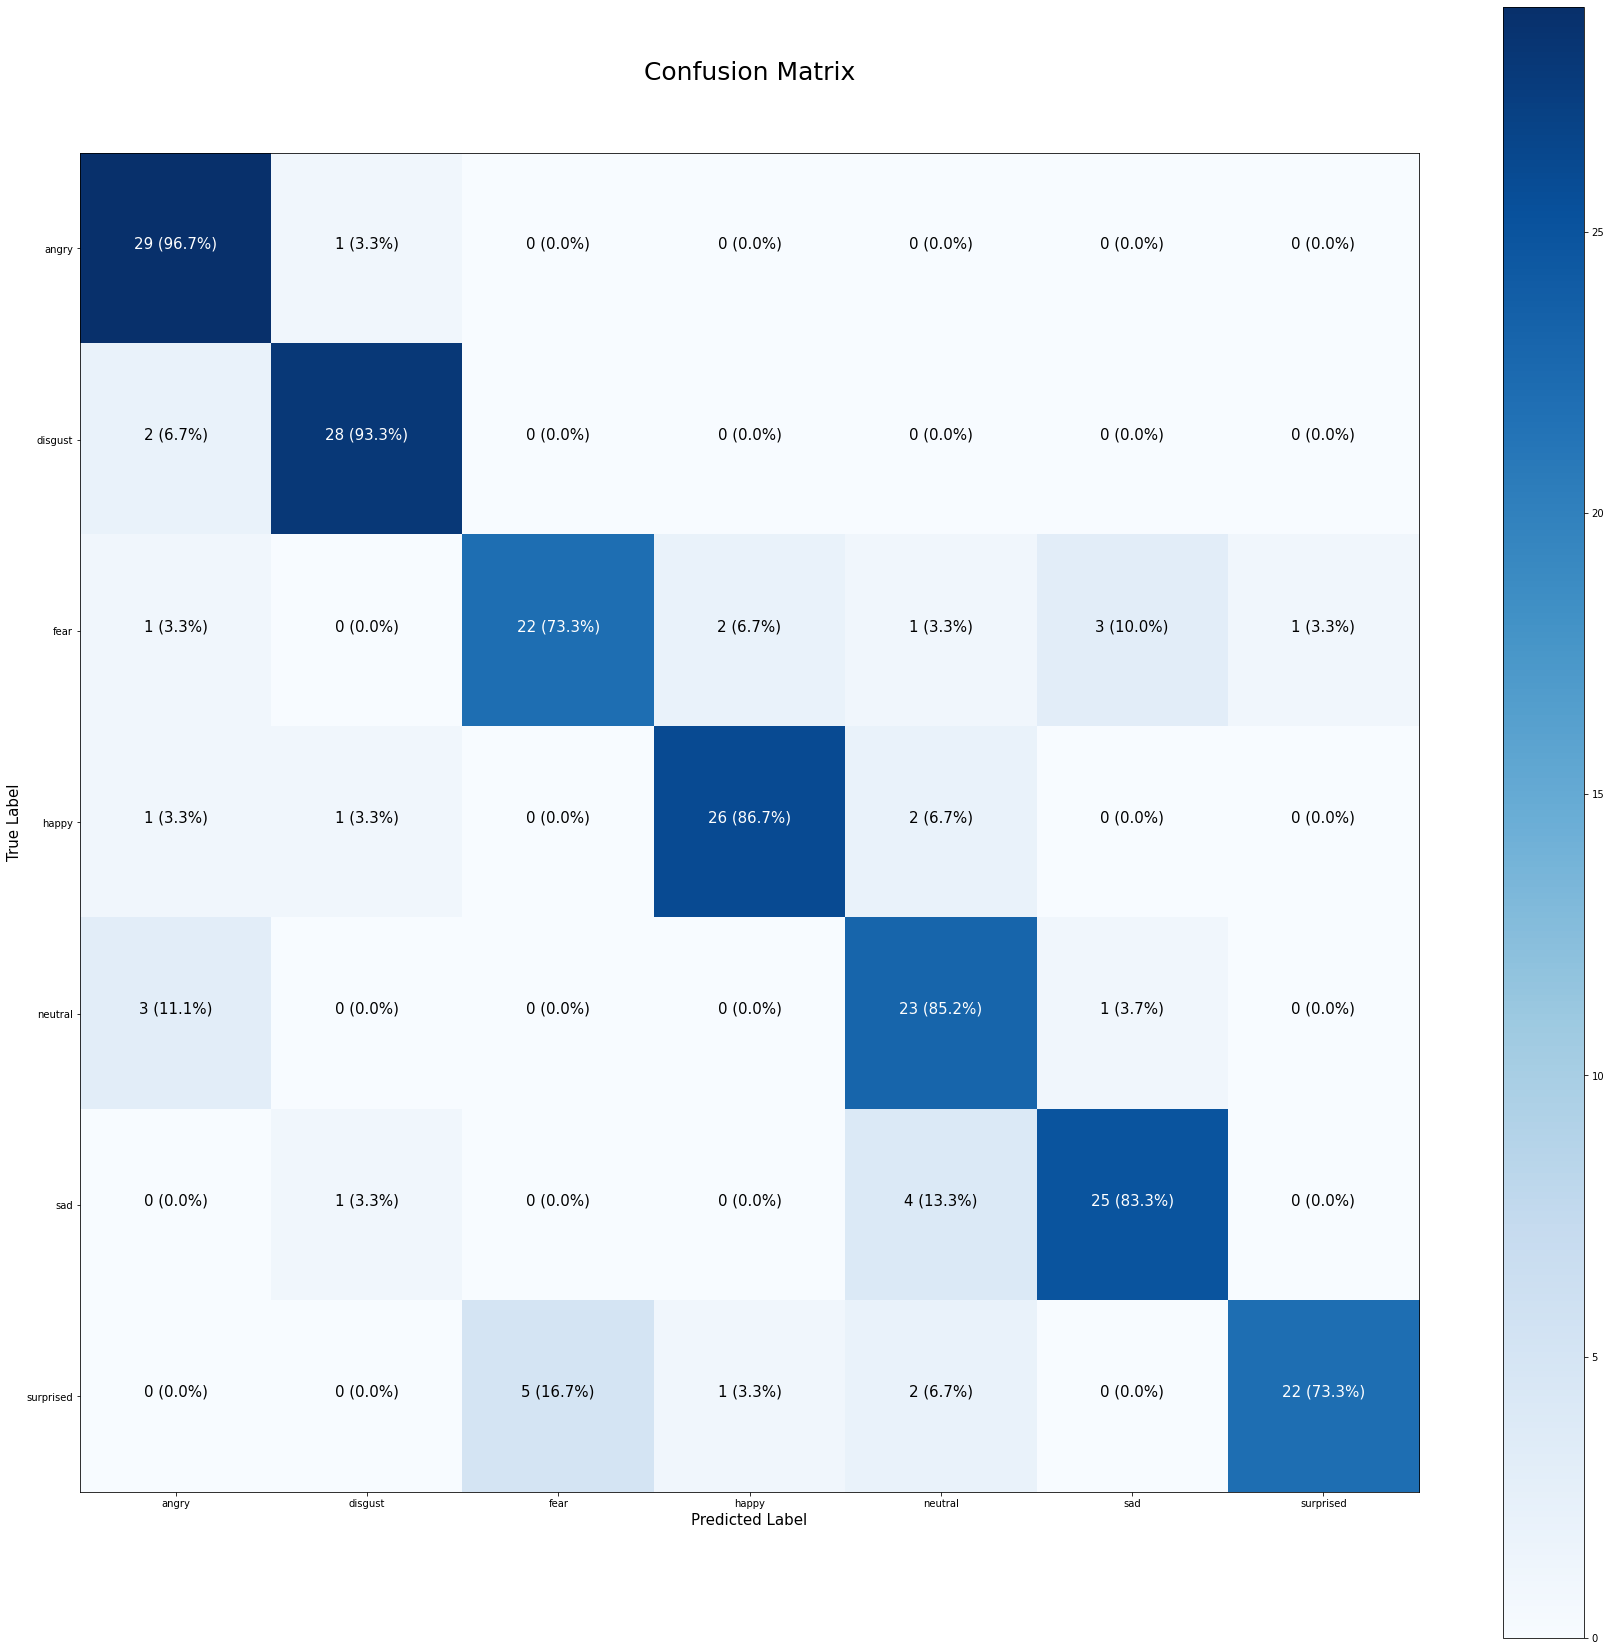

In [ ]:
data_prob=model_18.predict(images)
preds=data_prob.argmax(axis=1)
class_names_1= ['angry', 'disgust', 'fear', 'happy', 'neutral',
               'sad', 'surprised']
real=labels.argmax(axis=1)
PrettyConfusionMatrix(y_true= real,
                      y_pred= preds,
                      classes=class_names_1,
                      figsize=(30,30),
                      text_size=15)

In [ ]:
from gc import callbacks
model_17= Sequential([
    Conv2D(filters=32, kernel_size=(5,5), activation="relu",input_shape=(48,48,1)),
    BatchNormalization(name='batchnorm_1'),
    Conv2D(64,2, activation="relu"),
    MaxPool2D(),
    Conv2D(128,2, activation="relu"),
    MaxPool2D(),
    Conv2D(128,3, activation="relu"),
    Dropout(0.3),
    MaxPool2D(),
    Flatten(),
    Dense(5000, activation="relu"),
    Dense(7, activation="softmax")
])
#Compile the model

model_17.compile(loss= "categorical_crossentropy",
                optimizer=Adam(lr=0.001),
                metrics=["accuracy"],
                )

#fit the model
history_17=model_17.fit(
    train_data,
    epochs=75,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps= len(test_data),
    )

Epoch 1/75


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


33/33 [==============================] - 15s 414ms/step - loss: 2.4149 - accuracy: 0.2724 - val_loss: 1.9349 - val_accuracy: 0.1932
Epoch 2/75
33/33 [==============================] - 13s 397ms/step - loss: 1.5586 - accuracy: 0.4000 - val_loss: 1.6459 - val_accuracy: 0.3671
Epoch 3/75
33/33 [==============================] - 13s 396ms/step - loss: 1.1965 - accuracy: 0.5467 - val_loss: 1.1458 - val_accuracy: 0.5990
Epoch 4/75
33/33 [==============================] - 13s 397ms/step - loss: 1.0103 - accuracy: 0.6076 - val_loss: 1.0945 - val_accuracy: 0.6329
Epoch 5/75
33/33 [==============================] - 13s 395ms/step - loss: 0.8511 - accuracy: 0.6962 - val_loss: 1.0272 - val_accuracy: 0.6280
Epoch 6/75
33/33 [==============================] - 14s 407ms/step - loss: 0.7871 - accuracy: 0.7105 - val_loss: 0.9051 - val_accuracy: 0.6618
Epoch 7/75
33/33 [==============================] - 13s 395ms/step - loss: 0.7270 - accuracy: 0.7210 - val_loss: 0.9412 - val_accuracy: 0.6329
Epoch 8/75